In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta 
from datetime import date
import numpy as np
from googletrans import Translator
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from geopy.geocoders import Nominatim



In [2]:
#Load the dataset
dataset=pd.read_csv("dataset_18032022_loans.csv", sep=";")
dataset.head()

,loanIdentifier,phone,firstName,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,other1,referrerCode,...,purposeTranslate,income,outstandingLoan,latitude,longitude,model,brand,sdk,ssaid,nbReim
0,100121936688,1208902003,عماد,24/03/1984,1,Cairo,أعمال حرة,married,3,NaN,...,Other / prefer not to say,12200.0,1.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,NaN,0.0
1,100272621005,1029819947,محمد عبد القادر محمد السيد,01/12/1994,1,Kaliobeya,Uber2,married,0,NaN,...,Other / prefer not to say,1500.0,0.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,NaN,0.0
2,100273979181,1021436869,محمد,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,0,NaN,...,Other / prefer not to say,5100.0,1.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,NaN,0.0
3,100442522165,1099436542,Mohamed,06/08/1984,1,Cairo,banker,unknown or widowed,3,NaN,...,NaN,NaN,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,6ac18489769cc1f2,0.0
4,101397970333,1117749131,محمد أحمد,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,3,NaN,...,Medical expenses,4500.0,1.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,NaN,2.0


# PREPROCESSING THE DATA

In [3]:
#drop useless columns
dataset.drop(["firstName","other1","free","extensionDays","reimbursmentEmail","reimbursmentHour","loanHour","orderID","ssaid"],axis=1, inplace=True)

In [4]:
#convert amount to integer
dataset.amount=[int(x) for x in dataset.amount]

#Delete amounts different from 500 and 1000
for i in range(len(dataset)):
    if (dataset['amount'][i]!=int(500)) and (dataset['amount'][i]!=int(1000)):
            dataset.drop([i],axis=0, inplace=True)
            print(i)

dataset.reset_index(drop=True, inplace=True)
dataset.head()

187
839


,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,referrerCode,referralCode,accountCreation,...,noIncome,purposeTranslate,income,outstandingLoan,latitude,longitude,model,brand,sdk,nbReim
0,100121936688,1208902003,24/03/1984,1,Cairo,أعمال حرة,married,NaN,801-404-387,19/10/2021 22:10,...,0.0,Other / prefer not to say,12200.0,1.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0
1,100272621005,1029819947,01/12/1994,1,Kaliobeya,Uber2,married,NaN,184-501-913,21/11/2021 02:14,...,0.0,Other / prefer not to say,1500.0,0.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0
2,100273979181,1021436869,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,NaN,174-756-740,10/10/2021 12:29,...,0.0,Other / prefer not to say,5100.0,1.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0
3,100442522165,1099436542,06/08/1984,1,Cairo,banker,unknown or widowed,NaN,244-622-759,14/12/2021 17:59,...,NaN,NaN,NaN,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0
4,101397970333,1117749131,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,NaN,675-310-418,07/10/2021 02:36,...,0.0,Medical expenses,4500.0,1.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0


In [5]:
#shape of the dataset
dataset.shape

(2011, 41)

## PROFESSION TRANSLATE AND PREPROCESSING:

In [6]:
#preview the professions in our dataset
professions=""
for prof in dataset.profession:
    professions=professions+str(prof)+";"
print(professions)

أعمال حرة;Uber2;موظف بشركه شيلد بايب لصناعه البلاستيك;banker;أعمال حره ;معلم اول;مهندسه;محامى بالشركه المصريه للاتصالات;اعمل حر سائق سيارة اوبر وكريم;تاجر ;ربه منزل;طالب ;موظف قطاع خاص;صاحب شركه ;student;Kamal Mohamed;صاحب عمل;كبير مخرجين مدير عام التلفزيون المصري الهيئة الوطنيةللاعلام;مدير مبيعات;قطاع خاص;أعمال حرة;مشرف بوابه بشركة المقاولون العرب ;owner king club service center;جليسه مسنين ;تجاره;معهد اداره وسكرتاريه;بكالوريوس تربيه نوعيه;Driver in Ericsson;موظف دعايه و اعلان;noras;موظف في شركة القائد للاعلاف ;تجاره ملابس;اعمال حرة ;خياط ومصمم ازياء ;طالب;حاصله علي بكالريوس تجاره;مراقب أمن ادارى شركة السويدى اليكتريك للابراج ;طالب ;مهن حره;بكالوريوس نظم معلومات ادارية;لايوجد;فنى رابع طباعه;لا يوجد;ارمله ;مدير;مقيم شعائر ;مطاعم;سائق ;عامل تستيف;كليه الحقوق جامعه الاسكندريه;اعمال حره;موظف بشركه;عامل عادي;باترونست كمبيوتر;عامل ;محاسب ف شركه منظفات ;صاحب عمل ;موظف ;بدون عمل  ;عامل;اصلاح وصيانة الحاسب الالي والشبكات ;فنى تبريد وتكييف;اخصائي ائتماني بنك المبادرة;طالبة;باعه ف محل ملابس;مندو

In [8]:
#!pip install googletrans==3.1.0a0

translator = Translator()

#create new column
dataset['profession_translate']=""

#translate professions
for i in range(len(dataset)):
    translated_text = translator.translate(str(dataset['profession'][i]), dest='en')
    dataset['profession_translate'][i]=translated_text.text


dataset.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3942679755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['profession_translate'][i]=translated_text.text


,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,referrerCode,referralCode,accountCreation,...,purposeTranslate,income,outstandingLoan,latitude,longitude,model,brand,sdk,nbReim,profession_translate
0,100121936688,1208902003,24/03/1984,1,Cairo,أعمال حرة,married,NaN,801-404-387,19/10/2021 22:10,...,Other / prefer not to say,12200.0,1.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0,free businees
1,100272621005,1029819947,01/12/1994,1,Kaliobeya,Uber2,married,NaN,184-501-913,21/11/2021 02:14,...,Other / prefer not to say,1500.0,0.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0,Uber2
2,100273979181,1021436869,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,NaN,174-756-740,10/10/2021 12:29,...,Other / prefer not to say,5100.0,1.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0,Employee at Shield Pipe for the plastics industry
3,100442522165,1099436542,06/08/1984,1,Cairo,banker,unknown or widowed,NaN,244-622-759,14/12/2021 17:59,...,NaN,NaN,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0,banker
4,101397970333,1117749131,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,NaN,675-310-418,07/10/2021 02:36,...,Medical expenses,4500.0,1.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0,free businees


In [9]:
#save the dataset as csv
#dataset.to_csv(r'C:\Users\Lenovo\Desktop\FORMAATION DATA JEDHA\FULLSTACK\FINAL PROJECT ZOLO\new1.csv', encoding='utf-8-sig')

In [10]:
pd.set_option("display.max_rows", 5000)
dataset.profession_translate.value_counts()


free businees                                                                                                        156
Student                                                                                                               73
Officer                                                                                                               31
Driver                                                                                                                27
not working                                                                                                           26
student                                                                                                               26
Factor                                                                                                                24
free work                                                                                                             23
housewife                       

In [11]:
#needed install for spacy

#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

In [12]:
#Create a column "profession_translate_clean" containing only alpha characters in lowercase
dataset['profession_translate_clean'] = dataset['profession_translate'].apply(lambda x: ''.join(ch for ch in x if ch.isalpha() or ch==" "))
dataset['profession_translate_clean'] = dataset['profession_translate_clean'].fillna('').apply(lambda x: x.lower())

#remove "not" from the stop words
STOP_WORDS.remove("not")


nlp = en_core_web_sm.load()

#remove stop words from profession_translate_clean column
dataset["profession_translate_clean"] = dataset["profession_translate_clean"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])



dataset.head(10)

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,referrerCode,referralCode,accountCreation,...,income,outstandingLoan,latitude,longitude,model,brand,sdk,nbReim,profession_translate,profession_translate_clean
0,100121936688,1208902003,24/03/1984,1,Cairo,أعمال حرة,married,NaN,801-404-387,19/10/2021 22:10,...,12200.0,1.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0,free businees,"[free, businee]"
1,100272621005,1029819947,01/12/1994,1,Kaliobeya,Uber2,married,NaN,184-501-913,21/11/2021 02:14,...,1500.0,0.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0,Uber2,[uber]
2,100273979181,1021436869,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,NaN,174-756-740,10/10/2021 12:29,...,5100.0,1.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0,Employee at Shield Pipe for the plastics industry,"[employee, shield, pipe, plastic, industry]"
3,100442522165,1099436542,06/08/1984,1,Cairo,banker,unknown or widowed,NaN,244-622-759,14/12/2021 17:59,...,NaN,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0,banker,[banker]
4,101397970333,1117749131,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,NaN,675-310-418,07/10/2021 02:36,...,4500.0,1.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0,free businees,"[free, businee]"
5,101674647581,1287439919,12/10/1981,0,Ismailia,معلم اول,unknown or widowed,NaN,321-262-517,22/11/2021 11:22,...,5000.0,0.0,30.612330,32.265370,Infinix X604,Infinix,29.0,0.0,first teacher,[teacher]
6,101886614898,1153542673,19/05/1986,0,Giza,مهندسه,unknown or widowed,NaN,229-567-901,09/12/2021 17:22,...,NaN,1.0,30.197266,31.137208,DUB-LX1,HUAWEI,27.0,0.0,Engineer,[engineer]
7,102380893337,1552277363,17/10/1976,1,El Menia,محامى بالشركه المصريه للاتصالات,married,NaN,793-737-890,03/10/2021 17:36,...,10500.0,0.0,0.000000,0.000000,Infinix X652A,Infinix,28.0,0.0,Lawyer at Telecom Egypt,"[lawyer, telecom, egypt]"
8,102431258073,1026925029,04/07/1993,1,Fayoum,اعمل حر سائق سيارة اوبر وكريم,single,NaN,798-452-351,14/11/2021 19:04,...,5000.0,0.0,30.227104,31.445898,Redmi Note 8 Pro,Redmi,30.0,0.0,Work as a free Uber and Careem driver,"[work, free, uber, careem, driver]"
9,102718516662,1023137339,06/12/1997,1,Ash Sharqia,تاجر,married,NaN,551-489-237,09/11/2021 14:46,...,5400.0,0.0,0.000000,0.000000,M2003J15SC,Redmi,30.0,0.0,merchant,[merchant]


In [13]:
#Create a clean list of professions
professions_list=[]
for profession in dataset.profession_translate_clean:
    professions_list=professions_list+profession

#count the number of element in the list
prof_words_count = Counter(professions_list)

print(prof_words_count)


Counter({'free': 204, 'businee': 156, 'student': 150, 'company': 126, 'owner': 108, 'work': 98, 'diploma': 86, 'employee': 82, 'bachelor': 82, 'sale': 73, 'manager': 71, 'driver': 60, 'hold': 60, 'officer': 59, 'technician': 57, 'representative': 53, 'service': 50, 'commerce': 46, 'supervisor': 40, 'security': 40, 'not': 40, 'worker': 39, 'private': 36, 'factor': 36, 'business': 35, 'university': 34, 'technical': 33, 'sector': 28, 'degree': 26, 'school': 26, 'faculty': 25, 'law': 25, 'store': 25, 'customer': 25, 'industry': 24, 'director': 24, 'accountant': 24, 'chef': 24, 'high': 24, 'engineer': 21, 'administrative': 21, 'specialist': 21, 'factory': 21, 'housewife': 20, 'general': 20, 'management': 20, ' ': 20, 'industrial': 20, 'shop': 20, 'trade': 19, 'institute': 19, 'clothing': 19, 'college': 18, 'office': 18, 'freelance': 18, 'marketing': 17, 'furniture': 17, 'carpenter': 17, 'maintenance': 16, 'contracting': 16, 'car': 16, 'uber': 15, 'computer': 15, 'clothe': 15, 'production': 

In [14]:
#create a list of words and a list of their values
key_list=[]
count_list=[]
for key, value in prof_words_count.items():
    key_list.append(key)
    count_list.append(value)

#create a dataframe to stock these lists and sort them by values
words_dataframe=pd.DataFrame(columns=['key_words', 'count'])   
words_dataframe['key_words']=key_list
words_dataframe['count']=count_list
words_dataframe.sort_values(by=['count'],ascending=False ,inplace=True, ignore_index=True)

words_dataframe.head(50)

,key_words,count
0,free,204
1,businee,156
2,student,150
3,company,126
4,owner,108
5,work,98
6,diploma,86
7,bachelor,82
8,employee,82
9,sale,73


In [15]:
print(words_dataframe.iloc[:50,1].sum())

2477


In [16]:
#create professions category from the used words in profession

dataset['professions_category']=dataset.profession_translate_clean
for index in range(len(dataset)):
    if any(word in dataset.professions_category[index] for word in ['free', 'freelance', 'freelancer']):
        dataset.professions_category[index]='freelance'
    elif any(word in dataset.professions_category[index] for word in ['student', 'faculty', 'high school']):
        dataset.professions_category[index]='student'
    elif any(word in dataset.professions_category[index] for word in ['driver', 'uber']):
        dataset.professions_category[index]='driver'
    elif any(word in dataset.professions_category[index] for word in ['owner']):
        dataset.professions_category[index]='business owner'
    elif any(word in dataset.professions_category[index] for word in ['diploma', 'diploa', 'bachelor', 'hold', 'degree']):
        dataset.professions_category[index]='unemployed with educational degree'
    elif 'manager' in dataset.professions_category[index]:
        dataset.professions_category[index]='manager'
    elif any(word in dataset.professions_category[index] for word in ['sale', 'salesman', 'sales', 'marketing', 'merchant']):
        dataset.professions_category[index]='sales'
    elif any(word in dataset.professions_category[index] for word in ['security', 'police', 'armed']):
        dataset.professions_category[index]='army, police & security'
    elif any(word in dataset.professions_category[index] for word in ['employee', 'officer', 'representative', 'administrative', 'private', 'worker', 'normal', 'operator', 'carpenter']):
        dataset.professions_category[index]='employee'
    elif any(word in dataset.professions_category[index] for word in ['technical', 'technician', 'electrician']):
        dataset.professions_category[index]='technician'
    elif any(word in dataset.professions_category[index] for word in ['not', 'wife']):
        dataset.professions_category[index]='unemployed'
    elif 'chef' in dataset.professions_category[index]:
        dataset.professions_category[index]='head cook'
    elif 'teacher' in dataset.professions_category[index]:
        dataset.professions_category[index]='teacher'
    elif 'supervisor' in dataset.professions_category[index]:
        dataset.professions_category[index]='supervisor'
    elif 'accountant' in dataset.professions_category[index]:
        dataset.professions_category[index]='accountant'
    elif 'engineer' in dataset.professions_category[index]:
        dataset.professions_category[index]='engineer'
    elif 'director' in dataset.professions_category[index]:
        dataset.professions_category[index]='director'
    else:
        dataset.professions_category[index]='other'


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3702887747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.professions_category[index]='freelance'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3702887747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.professions_category[index]='driver'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3702887747.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

In [17]:
dataset.head(10)

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,referrerCode,referralCode,accountCreation,...,outstandingLoan,latitude,longitude,model,brand,sdk,nbReim,profession_translate,profession_translate_clean,professions_category
0,100121936688,1208902003,24/03/1984,1,Cairo,أعمال حرة,married,NaN,801-404-387,19/10/2021 22:10,...,1.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0,free businees,"[free, businee]",freelance
1,100272621005,1029819947,01/12/1994,1,Kaliobeya,Uber2,married,NaN,184-501-913,21/11/2021 02:14,...,0.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0,Uber2,[uber],driver
2,100273979181,1021436869,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,NaN,174-756-740,10/10/2021 12:29,...,1.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0,Employee at Shield Pipe for the plastics industry,"[employee, shield, pipe, plastic, industry]",employee
3,100442522165,1099436542,06/08/1984,1,Cairo,banker,unknown or widowed,NaN,244-622-759,14/12/2021 17:59,...,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0,banker,[banker],other
4,101397970333,1117749131,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,NaN,675-310-418,07/10/2021 02:36,...,1.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0,free businees,"[free, businee]",freelance
5,101674647581,1287439919,12/10/1981,0,Ismailia,معلم اول,unknown or widowed,NaN,321-262-517,22/11/2021 11:22,...,0.0,30.612330,32.265370,Infinix X604,Infinix,29.0,0.0,first teacher,[teacher],teacher
6,101886614898,1153542673,19/05/1986,0,Giza,مهندسه,unknown or widowed,NaN,229-567-901,09/12/2021 17:22,...,1.0,30.197266,31.137208,DUB-LX1,HUAWEI,27.0,0.0,Engineer,[engineer],engineer
7,102380893337,1552277363,17/10/1976,1,El Menia,محامى بالشركه المصريه للاتصالات,married,NaN,793-737-890,03/10/2021 17:36,...,0.0,0.000000,0.000000,Infinix X652A,Infinix,28.0,0.0,Lawyer at Telecom Egypt,"[lawyer, telecom, egypt]",other
8,102431258073,1026925029,04/07/1993,1,Fayoum,اعمل حر سائق سيارة اوبر وكريم,single,NaN,798-452-351,14/11/2021 19:04,...,0.0,30.227104,31.445898,Redmi Note 8 Pro,Redmi,30.0,0.0,Work as a free Uber and Careem driver,"[work, free, uber, careem, driver]",freelance
9,102718516662,1023137339,06/12/1997,1,Ash Sharqia,تاجر,married,NaN,551-489-237,09/11/2021 14:46,...,0.0,0.000000,0.000000,M2003J15SC,Redmi,30.0,0.0,merchant,[merchant],sales


In [18]:
#count the professions categories
dataset.professions_category.value_counts()

other                                 584
employee                              238
freelance                             228
unemployed with educational degree    173
student                               163
business owner                        107
sales                                  85
technician                             72
manager                                68
driver                                 67
army, police & security                54
unemployed                             52
accountant                             24
head cook                              24
supervisor                             23
engineer                               19
director                               16
teacher                                14
Name: professions_category, dtype: int64

In [19]:
#Preview the professions in other category


#Create a dataset containing only other
dataset_others=dataset[dataset.professions_category=='other']


professions_list1=[]
for profession in dataset_others.profession_translate_clean:
    professions_list1=professions_list1+profession


prof_words_count1 = Counter(professions_list1)


#create a list of words and their values
key_list1=[]
count_list1=[]
for key, value in prof_words_count1.items():
    key_list1.append(key)
    count_list1.append(value)

#create a dataframe to stock these lists and sort them by values
words_dataframe1=pd.DataFrame(columns=['key_words1', 'count1'])   
words_dataframe1['key_words1']=key_list1
words_dataframe1['count1']=count_list1
words_dataframe1.sort_values(by=['count1'],ascending=False ,inplace=True, ignore_index=True)

words_dataframe1.head(50)

,key_words1,count1
0,factor,32
1,company,30
2,housewife,20
3,school,20
4,work,18
5,high,18
6,service,17
7,specialist,16
8,trade,12
9,store,12


In [21]:
#save the dataset as csv
#dataset.to_csv(r'C:\Users\Lenovo\Desktop\FORMAATION DATA JEDHA\FULLSTACK\FINAL PROJECT ZOLO\dataset.csv', encoding='utf-8-sig')
#words_dataframe.to_csv(r'C:\Users\Lenovo\Desktop\FORMAATION DATA JEDHA\FULLSTACK\FINAL PROJECT ZOLO\words_dataframe.csv', encoding='utf-8-sig')

## ADD MOBILE OPERATORS

In [22]:
#convert phone column to str
dataset.phone=[str(x) for x in dataset.phone]

In [23]:
# Create a new columns "mobile_operator" using string indexing and replace them with the names of operators 
dataset['mobile_operator'] = dataset['phone'].str[0:2]
dataset.mobile_operator.value_counts()
for i in range(len(dataset)):
    if dataset.mobile_operator[i] == '10':
        dataset.mobile_operator[i]= 'vodafone'
    elif dataset.mobile_operator[i] == '11':
        dataset.mobile_operator[i] ='etisalat'
    elif dataset.mobile_operator[i] == '12':
        dataset.mobile_operator[i] ='orange'
    else:
        dataset.mobile_operator[i] ='we telecom'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3288091358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.mobile_operator[i] ='orange'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3288091358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.mobile_operator[i]= 'vodafone'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\3288091358.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.mobile_opera

In [24]:
dataset.head(10)

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,profession,maritalStatus,referrerCode,referralCode,accountCreation,...,latitude,longitude,model,brand,sdk,nbReim,profession_translate,profession_translate_clean,professions_category,mobile_operator
0,100121936688,1208902003,24/03/1984,1,Cairo,أعمال حرة,married,NaN,801-404-387,19/10/2021 22:10,...,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0,free businees,"[free, businee]",freelance,orange
1,100272621005,1029819947,01/12/1994,1,Kaliobeya,Uber2,married,NaN,184-501-913,21/11/2021 02:14,...,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0,Uber2,[uber],driver,vodafone
2,100273979181,1021436869,20/06/1988,1,Ash Sharqia,موظف بشركه شيلد بايب لصناعه البلاستيك,married,NaN,174-756-740,10/10/2021 12:29,...,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0,Employee at Shield Pipe for the plastics industry,"[employee, shield, pipe, plastic, industry]",employee,vodafone
3,100442522165,1099436542,06/08/1984,1,Cairo,banker,unknown or widowed,NaN,244-622-759,14/12/2021 17:59,...,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0,banker,[banker],other,vodafone
4,101397970333,1117749131,27/09/1998,1,Cairo,أعمال حره,unknown or widowed,NaN,675-310-418,07/10/2021 02:36,...,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0,free businees,"[free, businee]",freelance,etisalat
5,101674647581,1287439919,12/10/1981,0,Ismailia,معلم اول,unknown or widowed,NaN,321-262-517,22/11/2021 11:22,...,30.612330,32.265370,Infinix X604,Infinix,29.0,0.0,first teacher,[teacher],teacher,orange
6,101886614898,1153542673,19/05/1986,0,Giza,مهندسه,unknown or widowed,NaN,229-567-901,09/12/2021 17:22,...,30.197266,31.137208,DUB-LX1,HUAWEI,27.0,0.0,Engineer,[engineer],engineer,etisalat
7,102380893337,1552277363,17/10/1976,1,El Menia,محامى بالشركه المصريه للاتصالات,married,NaN,793-737-890,03/10/2021 17:36,...,0.000000,0.000000,Infinix X652A,Infinix,28.0,0.0,Lawyer at Telecom Egypt,"[lawyer, telecom, egypt]",other,we telecom
8,102431258073,1026925029,04/07/1993,1,Fayoum,اعمل حر سائق سيارة اوبر وكريم,single,NaN,798-452-351,14/11/2021 19:04,...,30.227104,31.445898,Redmi Note 8 Pro,Redmi,30.0,0.0,Work as a free Uber and Careem driver,"[work, free, uber, careem, driver]",freelance,vodafone
9,102718516662,1023137339,06/12/1997,1,Ash Sharqia,تاجر,married,NaN,551-489-237,09/11/2021 14:46,...,0.000000,0.000000,M2003J15SC,Redmi,30.0,0.0,merchant,[merchant],sales,vodafone


In [25]:
#remoove unusable features
dataset.drop(['profession','profession_translate','profession_translate_clean','banned','shadowBanned'], axis=1, inplace=True)


In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loanIdentifier             2011 non-null   int64  
 1   phone                      2011 non-null   object 
 2   birth                      2011 non-null   object 
 3   isMale                     2011 non-null   int64  
 4   birthGovernorateTranslate  2011 non-null   object 
 5   maritalStatus              2011 non-null   object 
 6   referrerCode               236 non-null    object 
 7   referralCode               2011 non-null   object 
 8   accountCreation            2011 non-null   object 
 9   detectionConfidence        2011 non-null   float64
 10  joyLikelihood              2011 non-null   object 
 11  sorrowLikelihood           2011 non-null   object 
 12  angerLikelihood            2011 non-null   object 
 13  surpriseLikelihood         2011 non-null   objec

## REPLACE MISSING VALUES

In [28]:
#Replace missing values in longitude and latitude with 0 (0 values already exist)
dataset.latitude.fillna(np.float64(0), inplace=True)
dataset.longitude.fillna(np.float64(0), inplace=True)

#Replace the missing values in model and brand with 'unknown'
dataset.model.fillna('unknown', inplace=True)
dataset.brand.fillna('unknown', inplace=True)

#Replace the missing values in sdk with the most frequent value
dataset.sdk=[str(x) for x in dataset.sdk]
for i in range(len(dataset)):
    if dataset.sdk[i] == 'nan':
        dataset.sdk[i] =dataset.sdk.mode()

#Replace the missing values in referrerCode with 'no_referrer'
dataset.referrerCode.fillna('no_referrer', inplace=True)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2232979227.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.sdk[i] =dataset.sdk.mode()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2232979227.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.sdk[i] =dataset.sdk.mode()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2232979227.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.sdk[i] =dataset.

## PREPROCESS DATES

In [30]:
#convert dates
dataset['birth']=[(datetime.strptime(str(x), '%d/%m/%Y')).date()  for x in dataset['birth']]
dataset['accountCreation']=[(datetime.strptime(x, '%d/%m/%Y %H:%M'))  for x in dataset['accountCreation']]
dataset['proposalDate']=[(datetime.strptime(x, '%d/%m/%Y')).date()  for x in dataset['proposalDate']]
dataset['cashedOutDate']=[(datetime.strptime(str(x), '%d/%m/%Y')).date()  for x in dataset['cashedOutDate']]
dataset['dueDate']=[(datetime.strptime(x, '%d/%m/%Y')).date()  for x in dataset['dueDate']]

In [31]:
#freez_date -> date of datasets export
freez_date=dt.date(2022,3,18)

#deys_delays created to checkout coherance of delays
dataset['days_delay']= dataset.dueDate -dataset.cashedOutDate

dataset.days_delay=[int(x.days) for x in dataset.days_delay ]
dataset.days_delay.value_counts()

71    2007
70       4
Name: days_delay, dtype: int64

In [32]:
#incoherance of values in column outstandingLoan
dataset.drop(['outstandingLoan'],axis=1, inplace=True)

In [33]:
#create a column for the loans in progress (due date + 20 days < freez date) and drop rows where loans still in progress
dataset['in_progress_loans']=''
for i in range(len(dataset)):
    dataset.in_progress_loans[i]=(dataset.dueDate[i] + timedelta(days=20)>= freez_date) and (str(dataset.reimbursmentDate[i])=='nan')
    if dataset.in_progress_loans[i]:
        dataset.drop([i],inplace=True)

#reset index
dataset.reset_index(drop=True, inplace=True)

#drop the column in_progress_loans
dataset.drop(['in_progress_loans'], inplace=True, axis=1)
dataset.head()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\439142601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.in_progress_loans[i]=(dataset.dueDate[i] + timedelta(days=20)>= freez_date) and (str(dataset.reimbursmentDate[i])=='nan')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\439142601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.in_progress_loans[i]=(dataset.dueDate[i] + timedelta(days=20)>= freez_date) and (str(dataset.reimbursmentDate[i])=='nan')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\439142601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,maritalStatus,referrerCode,referralCode,accountCreation,detectionConfidence,...,income,latitude,longitude,model,brand,sdk,nbReim,professions_category,mobile_operator,days_delay
0,100121936688,1208902003,1984-03-24,1,Cairo,married,no_referrer,801-404-387,2021-10-19 22:10:00,0.716062,...,12200.0,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0.0,freelance,orange,71
1,100272621005,1029819947,1994-12-01,1,Kaliobeya,married,no_referrer,184-501-913,2021-11-21 02:14:00,0.910078,...,1500.0,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0.0,driver,vodafone,71
2,100273979181,1021436869,1988-06-20,1,Ash Sharqia,married,no_referrer,174-756-740,2021-10-10 12:29:00,0.796427,...,5100.0,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0.0,employee,vodafone,71
3,100442522165,1099436542,1984-08-06,1,Cairo,unknown or widowed,no_referrer,244-622-759,2021-12-14 17:59:00,0.923198,...,NaN,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0.0,other,vodafone,71
4,101397970333,1117749131,1998-09-27,1,Cairo,unknown or widowed,no_referrer,675-310-418,2021-10-07 02:36:00,0.900118,...,4500.0,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2.0,freelance,etisalat,71


In [34]:

#create target column
dataset['target']=''

for i in range(len(dataset)):
    if str(dataset.reimbursmentDate[i])=='nan':
        dataset.target[i]='unpaid'
    elif dataset.dueDate[i] < datetime.strptime(dataset.reimbursmentDate[i], '%d/%m/%Y').date():
        dataset.target[i]="paid_with_delay"
    else: 
        dataset.target[i]='paid_in_time'


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\1211325532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.target[i]='paid_in_time'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\1211325532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.target[i]='unpaid'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\1211325532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.target[i]="paid_with_delay"


## REPLACE MISSING VALUES

In [36]:
#replace missing values with 'unkown'
dataset.haveAJob=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.haveAJob ]
dataset.selfEmployed=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.selfEmployed ]
dataset.student=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.student ]
dataset.noIncome=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.noIncome ]
dataset.educationLevelTranslate=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.educationLevelTranslate ]
dataset.purposeTranslate=[str(x) if str(x)!='nan' else 'unkown' for x in dataset.purposeTranslate ]

#replace nb of reimboursment missing values with 0
dataset.nbReim=[np.int64(x) if str(x)!='nan' else np.int64(0) for x in dataset.nbReim ]

#Replace missing values of beneAcccount with phone number of the user
for i in range(len(dataset)):
    dataset.beneAccount[i]=str(dataset.beneAccount[i])
    if dataset.beneAccount[i]=='nan':
        dataset.beneAccount[i]=dataset.phone[i]


#Replace missing income values
for i in range(len(dataset)):
    income_mean=dataset.income.mean()
    if str(dataset.income[i]) =='nan':
        if (dataset.haveAJob[i]=='1.0') or (dataset.selfEmployed[i]=='1.0') or (dataset.noIncome[i]=='0.0'):
            dataset.income[i]=income_mean
        else:   
            dataset.income[i]=np.float64(0)
   




C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2744218264.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.beneAccount[i]=str(dataset.beneAccount[i])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2744218264.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.income[i]=np.float64(0)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\2744218264.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.inc

"\nTo use only for KNNImputer\n\nfor i in range(len(dataset)):\n    if str(dataset.income[i]) =='nan':\n        if (dataset.haveAJob[i]=='0.0') and (dataset.selfEmployed[i]=='0.0') and (dataset.noIncome[i]=='1.0'):\n            dataset.income[i]=np.float64(0)\n"

In [37]:
dataset.head()

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,maritalStatus,referrerCode,referralCode,accountCreation,detectionConfidence,...,latitude,longitude,model,brand,sdk,nbReim,professions_category,mobile_operator,days_delay,target
0,100121936688,1208902003,1984-03-24,1,Cairo,married,no_referrer,801-404-387,2021-10-19 22:10:00,0.716062,...,30.064657,31.255474,Redmi Note 9S,Redmi,29.0,0,freelance,orange,71,paid_in_time
1,100272621005,1029819947,1994-12-01,1,Kaliobeya,married,no_referrer,184-501-913,2021-11-21 02:14:00,0.910078,...,30.478274,31.183525,DUB-LX1,HUAWEI,27.0,0,driver,vodafone,71,unpaid
2,100273979181,1021436869,1988-06-20,1,Ash Sharqia,married,no_referrer,174-756-740,2021-10-10 12:29:00,0.796427,...,0.000000,0.000000,DUB-LX1,HUAWEI,27.0,0,employee,vodafone,71,unpaid
3,100442522165,1099436542,1984-08-06,1,Cairo,unknown or widowed,no_referrer,244-622-759,2021-12-14 17:59:00,0.923198,...,31.105233,29.749146,Nokia 1.4,Nokia,30.0,0,other,vodafone,71,unpaid
4,101397970333,1117749131,1998-09-27,1,Cairo,unknown or widowed,no_referrer,675-310-418,2021-10-07 02:36:00,0.900118,...,0.000000,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2,freelance,etisalat,71,unpaid


In [38]:
#convert data
dataset.beneAccount=[str(x)for x in dataset.beneAccount]
dataset.isMale=[str(x)for x in dataset.isMale]
dataset.sdk=[np.float64(x)for x in dataset.sdk]

In [39]:
#save the dataset as csv
#dataset.to_csv(r'C:\Users\Lenovo\Desktop\FORMAATION DATA JEDHA\FULLSTACK\FINAL PROJECT ZOLO\clean_dataset.csv', encoding='utf-8-sig')

## CONTACT DATASET PREPROCESSING 

In [42]:
#import contact dataset
df_contact=pd.read_csv("usersContacts(1).csv")

In [43]:
#standardise contactphone column in df_contact 
df_contact['contactPhone']=[ x[3:] if x[0]=='+' else x[1:] for x in df_contact.contactPhone ]

In [44]:
#drop unused columns
dataset_loan_contact=dataset.loc[:,['loanIdentifier','phone']]

In [45]:
#merge dataset_loan_contact with df_contact 
df_final = dataset_loan_contact.merge(df_contact, left_on='phone', right_on='contactPhone', how='right')

In [46]:
#add column to identify from the contact list the ones which have loans
df_final['has_loan']=df_final.loanIdentifier_x.isna()==False

In [47]:
#drop unused columns
df_final=df_final.drop(['contactEmail', 'pkUsersContacts'], axis=1)

In [48]:
#merge df_final with dataset_loan_contact to delete loanIdentifiers with no loans
df_final2 = df_final.merge(dataset_loan_contact, left_on='loanIdentifier_y', right_on='loanIdentifier', how='inner')

In [49]:
#count the number of users having this phone number in thein contact list
df_nb_contact_per_user=df_final2.groupby("loanIdentifier_x").count()
df_nb_contact_per_user.drop(["loanIdentifier_y","contactName","contactPhone","has_loan","loanIdentifier","phone_y"],axis=1, inplace=True)
df_nb_contact_per_user.rename(columns={"phone_x":"nomber_of_zolo_contacts"}, inplace=True)
df_nb_contact_per_user.head()

,nomber_of_zolo_contacts
loanIdentifier_x,
1.564193e+09,4
2.479673e+09,1
2.831259e+09,2
4.986200e+09,1
5.193347e+09,3


## MERGE DATASETS

In [51]:
#merge df_nb_contact_per_user with dataset
clean_loan_dataset= dataset.merge(df_nb_contact_per_user, left_on='loanIdentifier', right_on='loanIdentifier_x', how='outer')
clean_loan_dataset.head(10)

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,maritalStatus,referrerCode,referralCode,accountCreation,detectionConfidence,...,longitude,model,brand,sdk,nbReim,professions_category,mobile_operator,days_delay,target,nomber_of_zolo_contacts
0,100121936688,1208902003,1984-03-24,1,Cairo,married,no_referrer,801-404-387,2021-10-19 22:10:00,0.716062,...,31.255474,Redmi Note 9S,Redmi,29.0,0,freelance,orange,71,paid_in_time,NaN
1,100272621005,1029819947,1994-12-01,1,Kaliobeya,married,no_referrer,184-501-913,2021-11-21 02:14:00,0.910078,...,31.183525,DUB-LX1,HUAWEI,27.0,0,driver,vodafone,71,unpaid,NaN
2,100273979181,1021436869,1988-06-20,1,Ash Sharqia,married,no_referrer,174-756-740,2021-10-10 12:29:00,0.796427,...,0.000000,DUB-LX1,HUAWEI,27.0,0,employee,vodafone,71,unpaid,NaN
3,100442522165,1099436542,1984-08-06,1,Cairo,unknown or widowed,no_referrer,244-622-759,2021-12-14 17:59:00,0.923198,...,29.749146,Nokia 1.4,Nokia,30.0,0,other,vodafone,71,unpaid,NaN
4,101397970333,1117749131,1998-09-27,1,Cairo,unknown or widowed,no_referrer,675-310-418,2021-10-07 02:36:00,0.900118,...,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2,freelance,etisalat,71,unpaid,2.0
5,101674647581,1287439919,1981-10-12,0,Ismailia,unknown or widowed,no_referrer,321-262-517,2021-11-22 11:22:00,0.923626,...,32.265370,Infinix X604,Infinix,29.0,0,teacher,orange,71,paid_in_time,NaN
6,101886614898,1153542673,1986-05-19,0,Giza,unknown or widowed,no_referrer,229-567-901,2021-12-09 17:22:00,0.579329,...,31.137208,DUB-LX1,HUAWEI,27.0,0,engineer,etisalat,71,paid_in_time,2.0
7,102431258073,1026925029,1993-07-04,1,Fayoum,single,no_referrer,798-452-351,2021-11-14 19:04:00,0.667880,...,31.445898,Redmi Note 8 Pro,Redmi,30.0,0,freelance,vodafone,71,unpaid,1.0
8,102718516662,1023137339,1997-12-06,1,Ash Sharqia,married,no_referrer,551-489-237,2021-11-09 14:46:00,0.803798,...,0.000000,M2003J15SC,Redmi,30.0,0,sales,vodafone,71,unpaid,NaN
9,102802565526,1022135510,1985-01-10,0,Cairo,unknown or widowed,no_referrer,222-548-176,2021-10-24 18:12:00,0.624744,...,0.000000,CPH2159,OPPO,30.0,0,other,vodafone,71,paid_in_time,2.0


In [ ]:
#Replace nomber_of_zolo_contacts missing values with 0
clean_loan_dataset['nomber_of_zolo_contacts']=clean_loan_dataset['nomber_of_zolo_contacts'].fillna(0)

## PREPROCESSING LOCATION

In [54]:
#replacing gps coordinates with city name

latitude_list=dataset.latitude.to_list()
longitude_list=dataset.longitude.to_list()


geolocator = Nominatim(user_agent="http")
location = [geolocator.reverse(str(lat)+','+ str(lon),language='en') for lat, lon in zip(latitude_list,longitude_list)]
cities_list=[x.raw.get('address').get('city') for x in location]
dataset["location_city"]=cities_list

#replace missing values with "unknown"
dataset.location_city.fillna('unknown', inplace=True)

In [55]:
dataset.head()

,loanIdentifier,phone,birth,isMale,birthGovernorateTranslate,maritalStatus,referrerCode,referralCode,accountCreation,detectionConfidence,...,longitude,model,brand,sdk,nbReim,professions_category,mobile_operator,days_delay,target,location_city
0,100121936688,1208902003,1984-03-24,1,Cairo,married,no_referrer,801-404-387,2021-10-19 22:10:00,0.716062,...,31.255474,Redmi Note 9S,Redmi,29.0,0,freelance,orange,71,paid_in_time,Cairo
1,100272621005,1029819947,1994-12-01,1,Kaliobeya,married,no_referrer,184-501-913,2021-11-21 02:14:00,0.910078,...,31.183525,DUB-LX1,HUAWEI,27.0,0,driver,vodafone,71,unpaid,Banha
2,100273979181,1021436869,1988-06-20,1,Ash Sharqia,married,no_referrer,174-756-740,2021-10-10 12:29:00,0.796427,...,0.000000,DUB-LX1,HUAWEI,27.0,0,employee,vodafone,71,unpaid,unknown
3,100442522165,1099436542,1984-08-06,1,Cairo,unknown or widowed,no_referrer,244-622-759,2021-12-14 17:59:00,0.923198,...,29.749146,Nokia 1.4,Nokia,30.0,0,other,vodafone,71,unpaid,unknown
4,101397970333,1117749131,1998-09-27,1,Cairo,unknown or widowed,no_referrer,675-310-418,2021-10-07 02:36:00,0.900118,...,0.000000,HUAWEI KII-L21,HUAWEI,23.0,2,freelance,etisalat,71,unpaid,unknown


## OTHER PREPROCESSING

In [56]:
#count the number of loans per user at proposal date 
dataset['nb_loan']=0
for i in range(len(dataset)):
    for j in range(len(dataset)):
        if dataset.phone[i]==dataset.phone[j] and dataset.proposalDate[i]>=dataset.proposalDate[j]:
            dataset.nb_loan[i]=dataset.nb_loan[i]+1


#create column of age
today=date.today()
dataset['age']=[(today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day)) ) for birthdate in dataset.birth]

#replace proposalDate with columns (proposal_dow:proposal_day_of_the_week and month) 
dataset['proposal_dow']=[str(x.weekday()) for x in dataset.proposalDate]
dataset['proposal_month']=[str(x.month) for x in dataset.proposalDate ]

#create a column with the number of used referralCode per user
dict_code_used=dict(dataset.referrerCode.value_counts())
dataset['nb_people_referred']=[dict_code_used[x] if x in dict_code_used  else 0 for x in dataset.referralCode]

#place the brands with unique value in "other" category 
dict_brands=dict(dataset.brand.value_counts())
listofbrands=[]
for k, v in dict_brands.items():
        if v==1:
            listofbrands.append(k)
dataset.brand=[x if x not in listofbrands else "other" for x in dataset.brand]


#place the location city with unique value in "other" category 
dict_cities=dict(dataset.location_city.value_counts())
listofcities=[]
for k, v in dict_cities.items():
        if v==1:
            listofcities.append(k)
dataset.location_city=[x if x not in listofcities else "other" for x in dataset.location_city]

#place the model with unique value in "other" category 
dict_model=dict(dataset.model.value_counts())
listofmodels=[]
for k, v in dict_model.items():
        if v==1:
            listofmodels.append(k)
dataset.model=[x if x not in listofmodels else "other" for x in dataset.model]

#add a column same Beneaccount 
dataset['sameBeneaccount']=''
for i in range (len(dataset)):
    if dataset.beneAccount[i]==dataset.phone[i]:
        dataset['sameBeneaccount'][i]="1"
    else:
        dataset['sameBeneaccount'][i]="0"

#create a column nb_day_creation_proposal to calculate the nomber of days between account creation and loan proposal date
dataset["nb_day_creation_proposal"]=''
dataset["nb_day_creation_proposal"]=[int((proposal-creation.date()).days) for proposal,creation in zip(dataset.proposalDate,dataset.accountCreation)]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\4041489142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.nb_loan[i]=dataset.nb_loan[i]+1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\4041489142.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sameBeneaccount'][i]="0"
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13836\4041489142.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sameBeneacco

In [57]:
#delete columns
dataset.drop(['days_delay','loanIdentifier','reimbursmentDate','birth','phone',"proposalDate","referrerCode","referralCode","cashedOutDate","dueDate","latitude","longitude","accountCreation","beneAccount","model","angerLikelihood","surpriseLikelihood","sorrowLikelihood"],inplace=True, axis=1)

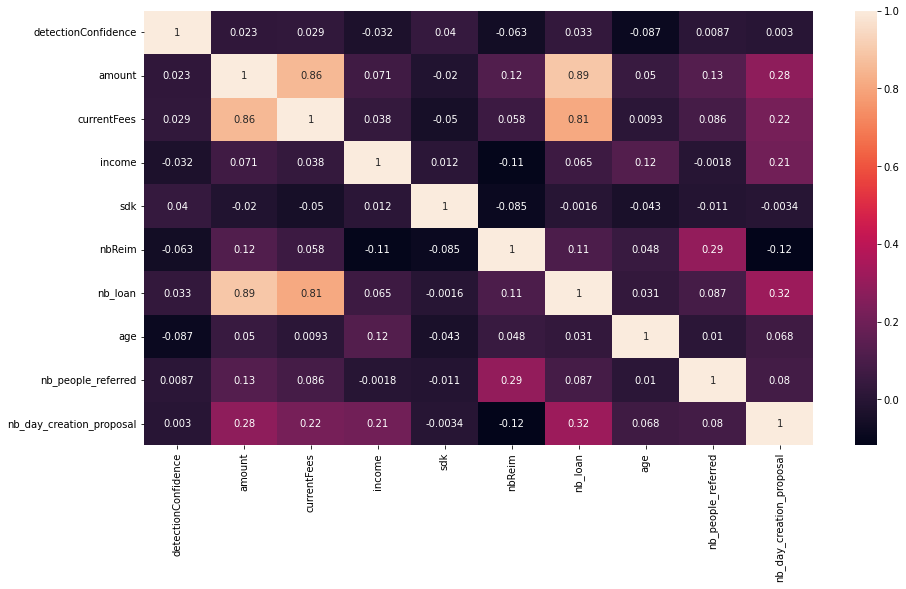

In [58]:
import seaborn as sns
from matplotlib import pyplot as plt
corr_dataset = dataset.corr(method='pearson')

plt.figure(figsize=(15, 8))
sns.heatmap(corr_dataset, annot=True)
plt.show()

#even if the columns currentFees, amount and nb_loan are correlated we keep them because we obtain a better auc_roc score 

In [60]:
dataset.head()

,isMale,birthGovernorateTranslate,maritalStatus,detectionConfidence,joyLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood,amount,currentFees,...,mobile_operator,target,location_city,nb_loan,age,proposal_dow,proposal_month,nb_people_referred,sameBeneaccount,nb_day_creation_proposal
0,1,Cairo,married,0.716062,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,UNLIKELY,500,20,...,orange,paid_in_time,Cairo,1,38,3,12,0,0,58
1,1,Kaliobeya,married,0.910078,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,500,60,...,vodafone,unpaid,Banha,1,27,3,11,0,0,4
2,1,Ash Sharqia,married,0.796427,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,500,60,...,vodafone,unpaid,unknown,1,33,2,12,0,0,66
3,1,Cairo,unknown or widowed,0.923198,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,500,60,...,vodafone,unpaid,unknown,1,37,2,12,0,0,1
4,1,Cairo,unknown or widowed,0.900118,LIKELY,VERY_UNLIKELY,VERY_UNLIKELY,VERY_UNLIKELY,500,60,...,etisalat,unpaid,unknown,1,23,4,12,2,0,57


In [61]:
#add the name of the column in the feature to recognize them later  in the feature importance
dataset.joyLikelihood=[(x+"_joyLikelihood") for x in dataset.joyLikelihood ]
dataset.underExposedLikelihood=[(x+"_underExposedLikelihood") for x in dataset.underExposedLikelihood ]
dataset.blurredLikelihood=[(x+"_blurredLikelihood") for x in dataset.blurredLikelihood ]
dataset.headwearLikelihood=[(x+"_headwearLikelihood") for x in dataset.headwearLikelihood ]

In [62]:
#save the dataset as csv
dataset.to_csv(r'C:\Users\Lenovo\Desktop\FORMAATION DATA JEDHA\FULLSTACK\FINAL PROJECT ZOLO\clean_dataset2.csv', encoding='utf-8-sig', index=False)

# CLEAN DATASET EXPLORATION:

In [63]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 1873

Display of dataset: 


,isMale,birthGovernorateTranslate,maritalStatus,detectionConfidence,joyLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood,amount,currentFees,...,mobile_operator,target,location_city,nb_loan,age,proposal_dow,proposal_month,nb_people_referred,sameBeneaccount,nb_day_creation_proposal
0,1,Cairo,married,0.716062,VERY_UNLIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,UNLIKELY_headwearLikelihood,500,20,...,orange,paid_in_time,Cairo,1,38,3,12,0,0,58
1,1,Kaliobeya,married,0.910078,VERY_UNLIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,VERY_UNLIKELY_headwearLikelihood,500,60,...,vodafone,unpaid,Banha,1,27,3,11,0,0,4
2,1,Ash Sharqia,married,0.796427,VERY_UNLIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,VERY_UNLIKELY_headwearLikelihood,500,60,...,vodafone,unpaid,unknown,1,33,2,12,0,0,66
3,1,Cairo,unknown or widowed,0.923198,VERY_UNLIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,VERY_UNLIKELY_headwearLikelihood,500,60,...,vodafone,unpaid,unknown,1,37,2,12,0,0,1
4,1,Cairo,unknown or widowed,0.900118,LIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,VERY_UNLIKELY_headwearLikelihood,500,60,...,etisalat,unpaid,unknown,1,23,4,12,2,0,57



Basics statistics: 


,isMale,birthGovernorateTranslate,maritalStatus,detectionConfidence,joyLikelihood,underExposedLikelihood,blurredLikelihood,headwearLikelihood,amount,currentFees,...,mobile_operator,target,location_city,nb_loan,age,proposal_dow,proposal_month,nb_people_referred,sameBeneaccount,nb_day_creation_proposal
count,1873,1873,1873,1873.000000,1873,1873,1873,1873,1873.000000,1873.000000,...,1873,1873,1873,1873.000000,1873.000000,1873,1873,1873.000000,1873,1873.000000
unique,2,28,3,NaN,5,5,5,5,NaN,NaN,...,4,3,31,NaN,NaN,7,4,NaN,2,NaN
top,1,Cairo,married,NaN,VERY_UNLIKELY_joyLikelihood,VERY_UNLIKELY_underExposedLikelihood,VERY_UNLIKELY_blurredLikelihood,VERY_UNLIKELY_headwearLikelihood,NaN,NaN,...,vodafone,paid_in_time,unknown,NaN,NaN,1,12,NaN,0,NaN
freq,1477,602,804,NaN,1145,1855,1860,1449,NaN,NaN,...,849,949,1031,NaN,NaN,406,1224,NaN,1672,NaN
mean,NaN,NaN,NaN,0.725077,NaN,NaN,NaN,NaN,549.919915,48.587827,...,NaN,NaN,NaN,1.120662,31.643887,NaN,NaN,0.139883,NaN,29.239188
std,NaN,NaN,NaN,0.162441,NaN,NaN,NaN,NaN,149.933190,39.523834,...,NaN,NaN,NaN,0.354105,8.642640,NaN,NaN,0.494279,NaN,24.436653
min,NaN,NaN,NaN,0.203680,NaN,NaN,NaN,NaN,500.000000,0.000000,...,NaN,NaN,NaN,1.000000,18.000000,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,0.629439,NaN,NaN,NaN,NaN,500.000000,20.000000,...,NaN,NaN,NaN,1.000000,25.000000,NaN,NaN,0.000000,NaN,9.000000
50%,NaN,NaN,NaN,0.754157,NaN,NaN,NaN,NaN,500.000000,20.000000,...,NaN,NaN,NaN,1.000000,31.000000,NaN,NaN,0.000000,NaN,22.000000
75%,NaN,NaN,NaN,0.850145,NaN,NaN,NaN,NaN,500.000000,60.000000,...,NaN,NaN,NaN,1.000000,37.000000,NaN,NaN,0.000000,NaN,46.000000



Percentage of missing values: 


isMale                       0.0
birthGovernorateTranslate    0.0
maritalStatus                0.0
detectionConfidence          0.0
joyLikelihood                0.0
underExposedLikelihood       0.0
blurredLikelihood            0.0
headwearLikelihood           0.0
amount                       0.0
currentFees                  0.0
educationLevelTranslate      0.0
haveAJob                     0.0
selfEmployed                 0.0
student                      0.0
noIncome                     0.0
purposeTranslate             0.0
income                       0.0
brand                        0.0
sdk                          0.0
nbReim                       0.0
professions_category         0.0
mobile_operator              0.0
target                       0.0
location_city                0.0
nb_loan                      0.0
age                          0.0
proposal_dow                 0.0
proposal_month               0.0
nb_people_referred           0.0
sameBeneaccount              0.0
nb_day_cre

In [64]:
#distribution of the targets
dataset.target.value_counts()

paid_in_time       949
unpaid             668
paid_with_delay    256
Name: target, dtype: int64

In [65]:
#dataset shape
dataset.shape

(1873, 31)